<a href="https://colab.research.google.com/github/marcinwolter/DNN_examples/blob/master/dnn_tracking_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
Reconstructs straight tracks in 3D (with noise and inefficiency)
Using google TPUs to speed up the training
'''

from __future__ import print_function

!pip install keras_sequential_ascii




import matplotlib.pyplot as plt
# Package imports
import numpy as np
from scipy.stats import norm

import tensorflow as tf

import os
import pprint


from tensorflow.compat.v1.keras import backend as K
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Flatten
from tensorflow.compat.v1.keras.layers import Conv2D, MaxPooling2D, RepeatVector, LSTM, TimeDistributed
from tensorflow.compat.v1.keras.layers import Conv3D, MaxPooling3D
from tensorflow.compat.v1.keras.layers import Reshape
from tensorflow.compat.v1.keras.models import Sequential
from keras_sequential_ascii import sequential_model_to_ascii_printout
from tensorflow.compat.v1.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.compat.v1.keras.models import load_model
from tensorflow.compat.v1.keras.optimizers import SGD, RMSprop, Adam, Nadam

import sys
import time

np.random.seed(2348)

batch_size = 5000
batch_size_NN = 2*128 #128
epochs = 512 #512
pre_epochs =  16 #32 epochs for pre-traing using rms optimizer
post_epochs = 16 #64 post-training using SGD
steps_per_epoch = 2*8 #4*8

# input image dimensions
img_rows, img_cols = 28, 28  #28, 28


####################################################################################################

# Data parameters
det_width = img_rows  # stupid, to be changed
det_depth = img_cols
det_shape = (det_width, det_width, det_depth)


# Number of tracks in each event follows Poisson distribution
mean_tracks = 2
max_tracks  = 2

#probability of noise and the efficiency<1
prob_noise = 0.000
efficiency = 0.90

#slope multiplicator - reduce the slope to slope_mult*max_slope
slope_mult = 0.4


y_new = []

# ### Functions for toy data generation


def simulate_straight_track(b2x, bx, b2y, by, det_shape):
    """
    Simulate detector data for one straight track.
    Parameters:
        b2x, b2y: track last layer intercept
        bx, by: track first-layer intercept parameter (detector entry point)
        det_shape: tuple of detector shape: (width, width, depth)
    Returns:
        ndarray of binary detector data for one track.
    """
    x = np.zeros(det_shape)
    idz = np.arange(det_shape[2])
    hitsx = (idz*(b2x-bx)/det_depth + bx +0.5).astype(int)  ## +0.5 to get rounding, not clipping
    hitsy = (idz*(b2y-by)/det_depth + by +0.5).astype(int)  ## +0.5 to get rounding, not clipping
    # implement hit efficiency
    for i in range(det_shape[0]):
        if (np.random.random() > efficiency):
            hitsx[i]=0
            hitsy[i]=0
    #print ("HITS = ",hits)
    valid = (hitsx > 0) & (hitsx < det_shape[0]) & (hitsy > 0) & (hitsy < det_shape[1])
    x[hitsx[valid], hitsy[valid], idz[valid]] = 1
    return x

# Generator for single-track events
def gen_tracks(batch_size=batch_size, det_shape=det_shape):
    """Arguments:
         batch_size: number of events to yield for each call
       Yields: batches of training data for use with the keras fit_generator function
    """
    while True:
        # Entry and exit points are randomized
        bsx = np.random.random_sample(size=batch_size)*(det_width-6)+3
        b2sx = np.random.random_sample(size=batch_size)*(det_width-6)+3
        # restrict the slope of a track to slope_mult*slope
        b2sx = bsx + slope_mult*(b2sx-bsx)
        
        bsy = np.random.random_sample(size=batch_size)*(det_width-6)+3
        b2sy = np.random.random_sample(size=batch_size)*(det_width-6)+3
        # restrict the slope of a track to slope_mult*slope
        b2sy = bsy + slope_mult*(b2sy-bsy)
        
        tracks = np.zeros((batch_size, 1, det_depth, det_width, det_width))
        params = zip(bsx, b2sx, bsy, b2sy )
        for i, (pbx, pb2x, pby, pb2y) in enumerate(params):
            tracks[i,0] = simulate_straight_track(pb2x, pbx, pb2y, pby, det_shape)
###        targets = zip(bsx, msx, bsy, msy)
        targets = zip(bsx/det_width, (b2sx-bsx)/det_depth/slope_mult, 
                      bsy/det_width, (b2sy-bsy)/det_depth/slope_mult )  # save b and b2 as targets
        targets = np.asarray(targets)
        yield tracks, targets

# Generator for multi-track events.
# Each event contains exactly n_tracks tracks.
# The target track parameters are sorted in increasing order of X intercept.
def gen_n_tracks(batch_size=batch_size, det_shape=det_shape, n_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=n_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width, det_width))
#        batch_targets = -np.ones((batch_size, n_tracks, 4))
        batch_targets = -np.ones((batch_size, max_tracks, 4))
        #print("batch_targets 0 ",batch_targets.shape)
        for n in range(batch_size):
            tracks,targets = gen_single.next()
            batch_events[n,0] = np.clip( sum( tracks ), 0, 1)
            event_targets = np.asarray(targets)

            #print("event_targets",event_targets,targets)
            batch_targets[n] = event_targets[event_targets[:,0].argsort()] # sort by first column
            #add empty rows to get the size of max_tracks
            #for k in range(max_tracks-n_tracks):
            ###batch_targets[n] = event_targets  #do not sort
            #print("batch_events ",batch_events.shape)
            #print("batch_targets ",batch_targets.shape)
        yield batch_events, batch_targets

# Generator for multi-track events.
# Each event contains up to max_tracks tracks.
# The target track parameters are sorted in increasing order of intercept.
def gen_multi_tracks(batch_size=batch_size, det_shape=det_shape, mean_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=max_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width, det_width))
        batch_targets = -np.ones((batch_size, max_tracks, 4))
        for n in range(batch_size):
            num_tracks = min( max_tracks, np.random.poisson(mean_tracks) )
            tracks,targets = gen_single.next()
            batch_events[n,0] = np.clip( sum( tracks[:num_tracks] ), 0, 1)
            event_targets = np.asarray(targets[:num_tracks])
            batch_targets[n,:num_tracks] = event_targets[event_targets[:,0].argsort()] # sort by first column            
        yield batch_events, batch_targets


def gen_noise(batch_size=batch_size, det_shape=det_shape, prob_noise=prob_noise):

        batch_events = np.zeros((batch_size, 1, det_depth, det_width, det_width))
        for n in range(batch_size):

            for i in range(det_depth):
               for j in range(det_width):
                  for k in range(det_width):
                     if np.random.random()<prob_noise:
                        batch_events[n,0,i,j,k]=1


        yield batch_events


####################################################################################################





##########################################################################################

def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs



    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations




#####################################################################################


In [0]:

# the data, split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()


###x_train, y_train = gen_n_tracks(batch_size=batch_size).next()
x_test, y_test = gen_n_tracks(batch_size=batch_size, n_tracks=mean_tracks).next()

###y_train = y_train
###y_test = y_test

# add noise
###noise_train = gen_noise(batch_size=batch_size).next()
noise_test = gen_noise(batch_size=batch_size, prob_noise=prob_noise).next()
###x_train = x_train+noise_train
x_test  = x_test+noise_test


###print("x_train ",x_train.shape)
###print("y_train ",y_train.shape)




#print(x_train[0,0])
#print("Train targets ",y_train[0])
#print(x_test[0,0])
#print("Test targets ",y_test[0])


#
# if K.image_data_format() == 'channels_first':
#     x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#     x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     y_train = y_train.reshape(y_train.shape[0], 1, 2)
#     y_test = y_test.reshape(y_test.shape[0], 1, 2)
#     input_shape = (1, img_rows, img_cols)
# else:
#     x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#     x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
#     y_train = y_train.reshape(y_train.shape[0], 2, 1)
#     y_test = y_test.reshape(y_test.shape[0], 2, 1)
#     input_shape = (img_rows, img_cols, 1)

###x_train = x_train.astype('int')
x_test = x_test.astype('int')
###x_train = np.clip(x_train, 0, 1)
x_test = np.clip(x_test, 0, 1)
#x_train /= 255
#x_test /= 255
#print('x_train shape:', x_train.shape)
#print(x_train.shape[0], 'train samples')
#print(x_test.shape[0], 'test samples')
#print('y_train shape:', y_train.shape)
#print(y_train.shape[0], 'train samples')
#print(y_test.shape[0], 'test samples')

event_0.9_0.03_0.png


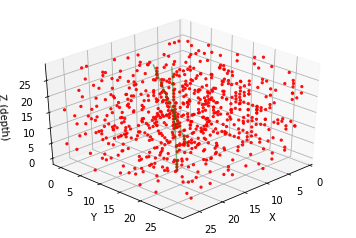

event_0.9_0.03_1.png


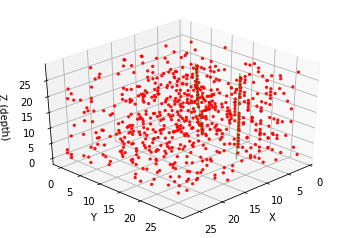

event_0.9_0.03_2.png


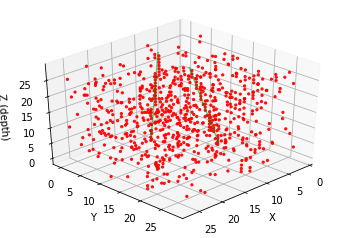

event_0.9_0.03_3.png


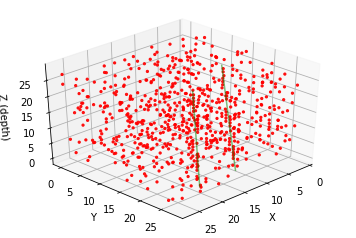

event_0.9_0.03_4.png


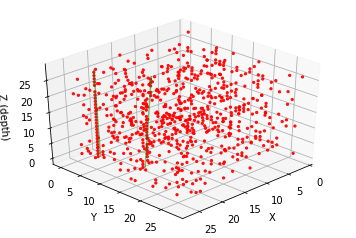

event_0.9_0.03_5.png


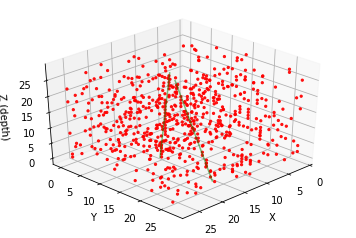

event_0.9_0.03_6.png


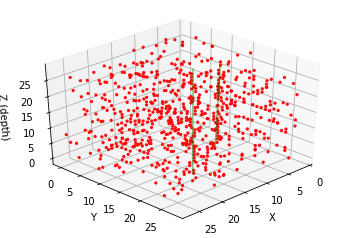

event_0.9_0.03_7.png


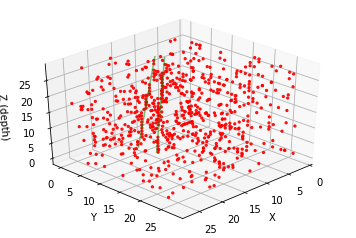

event_0.9_0.03_8.png


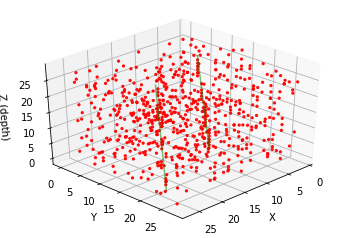

event_0.9_0.03_9.png


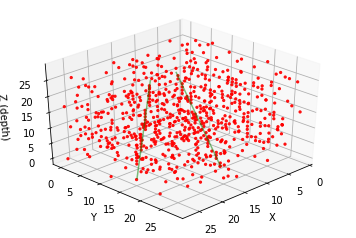

event_0.9_0.03_10.png


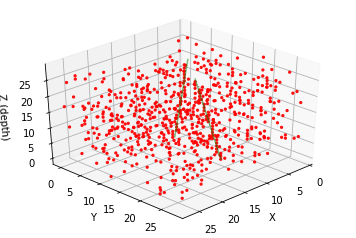

event_0.9_0.03_11.png


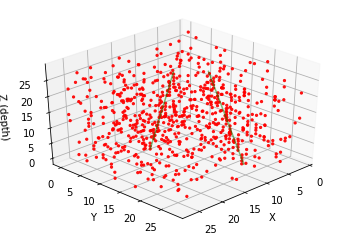

event_0.9_0.03_12.png


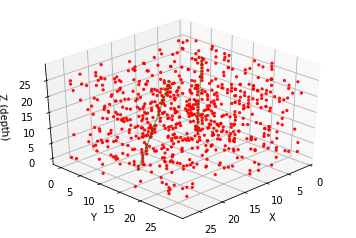

In [3]:
#plot sample events

#for n in range(min(16,len(x_train))):
#  plt.subplot(4, 4, n+1)
#  plt.imshow(x_train[n,0])


for n in range(1):
  for k in range(int(100*(prob_noise+0.10))):
    rnumber = np.random.randint(0,len(x_test))
    x,y,z = x_test[rnumber,0].nonzero()
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, zdir='z', c= 'red', s=5, alpha=0.9)
    
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z (depth)')
  
    
    for j in range(len(y_test[rnumber])):
    # Data for a three-dimensional line
       #print("index ",k,j)
       #print("ytrain ", y_train[rnumber])
       zline = np.linspace(0, 28, 100)
       xline = y_test[rnumber,j,0]*det_width+y_test[rnumber,j,1]*slope_mult*zline 
       yline = y_test[rnumber,j,2]*det_width+y_test[rnumber,j,3]*slope_mult*zline 
###       xline = 100*y_test[rnumber,k,0]+100/slope_scale*y_test[rnumber,k,1]*zline
###       yline = 100*y_test[rnumber,k,2]+100/slope_scale*y_test[rnumber,k,3]*zline
       ax.plot3D(xline, yline, zline,  'green', alpha=0.5)
    
    ax.view_init(elev=35., azim=45)
    ax.scatter([0,det_width],[0,det_width],[0,det_depth], c= 'blue', s=0)

    # set axes range
    ax.set_xlim3d(0,det_width)
    ax.set_xlim3d(0,det_width)
    ax.set_xlim3d(0,det_depth)
    #ax.axis('equal')
    
    print('event_'+str(efficiency)+"_"+str(prob_noise)+"_"+str(k)+'.png')
    plt.savefig('event_'+str(efficiency)+"_"+str(prob_noise)+"_"+str(k)+'.png')
    plt.show()
  
#  plt.imshow(x_train[np.random.randint(0,len(x_train)),0])
#  plt.show()
#   plt.savefig('event.png')
#plt.clf()





#for i in range(img_rows):
#    print (" ")
#    for j in range (img_cols):
#        print (x_train[0,0,i,j], end=' ')
#print (" ")
#print ("y_train[0] = ",y_train[0])
#print ("y_test[0] = ",y_test[0])


# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
#print ("Class = ",y_train[0])



#sys.exit("Stopping here")



In [4]:
#printing TPU information

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!


input_shape  (1, 28, 28, 28)


W1119 16:41:54.440414 139936381134720 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling __init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[<tf.Tensor 'reshape/Reshape:0' shape=(?, 28, 28, 28, 1) dtype=float32>, <tf.Tensor 'conv3d/Relu:0' shape=(?, 26, 26, 26, 32) dtype=float32>, <tf.Tensor 'conv3d_1/Relu:0' shape=(?, 24, 24, 24, 32) dtype=float32>, <tf.Tensor 'max_pooling3d/MaxPool3D:0' shape=(?, 12, 12, 12, 32) dtype=float32>, <tf.Tensor 'conv3d_2/Relu:0' shape=(?, 10, 10, 10, 128) dtype=float32>, <tf.Tensor 'conv3d_3/Relu:0' shape=(?, 8, 8, 8, 128) dtype=float32>, <tf.Tensor 'dropout/cond/Merge:0' shape=(?, 8, 8, 8, 128) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 65536) dtype=float32>, <tf.Tensor 'dense/Relu:0' shape=(?, 400) dtype=float32>, <tf.Tensor 'repeat_vector/Tile:0' shape=(?, 2, 400) dtype=float32>, <tf.Tensor 'lstm/transpose_1:0' shape=(?, 2, 400) dtype=float32>, <tf.Tensor 'time_distributed/Reshape_1:0' shape=(?, 2, 4) dtype=float32>, <tf.Tensor 'reshape_1/Reshape:0' shape=(?, 2, 4) dtype=float32>]
Model: "sequential"
_________________________________________________________________
Layer (type

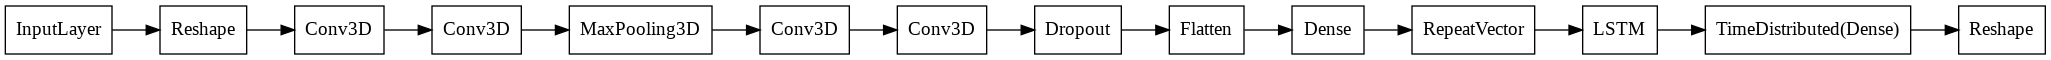

event_0.9_0.03_0.png   event_0.9_0.03_2.png  event_0.9_0.03_7.png
event_0.9_0.03_10.png  event_0.9_0.03_3.png  event_0.9_0.03_8.png
event_0.9_0.03_11.png  event_0.9_0.03_4.png  event_0.9_0.03_9.png
event_0.9_0.03_12.png  event_0.9_0.03_5.png  model.png
event_0.9_0.03_1.png   event_0.9_0.03_6.png  sample_data
Model shown
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####      1   28   28   28
             Reshape     |   -------------------         0     0.0%
                       #####     28   28   28    1
              Conv3D    \|/  -------------------       896     0.0%
                relu   #####     26   26   26   32
              Conv3D    \|/  -------------------     27680     0.0%
                relu   #####     24   24   24   32
        MaxPooling3D   Y max -------------------         0     0.0%
                       #####     12   12   12   32
              Conv3D    \|/  -------------------    110720     0.0%
         

In [5]:



start_training_time = time.time()

if 'COLAB_TPU_ADDR' not in os.environ:

  model = Sequential()
  input_shape=(1,det_width, det_width, det_depth)

  print("input_shape ",input_shape)

  model.add(Reshape((det_width, det_width, det_depth,1),
                                  input_shape=input_shape))
  model.add(Conv3D(32, (3, 3, 3), activation='relu'))  #8
  model.add(Conv3D(32, (3, 3, 3), activation='relu'))  #8
#  model.add(Conv3D(32, (3, 3, 3), activation='relu'))  #added
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(Conv3D(128, (3, 3, 3), activation='relu'))  #32
  model.add(Conv3D(128, (3, 3, 3), activation='relu'))  #32
#  model.add(Conv3D(128, (3, 3, 3), activation='relu'))  #added
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(400, activation='relu'))  # 400
#  model.add(Dense(400))  # added
  #model.add(Dropout(0.5))
  #model.add(Dense(2, activation='tanh'))


  model.add(RepeatVector(max_tracks))
  model.add(LSTM(400, return_sequences=True))
  model.add(TimeDistributed(Dense(4)))

  # model.add(Flatten(input_shape=input_shape))
  # #model.add(Reshape(input_shape - (1, ), input_shape=input_shape))
  # model.add(Dense(32, activation='relu'))
  # model.add(Dense(32, activation='relu'))
  # model.add(Dense(32, activation='relu'))
  # model.add(Dense(32, activation='relu'))
  # #model.add(Dense(32, activation='relu'))
  # #model.add(Dense(32, activation='relu'))
  # model.add(Dropout(0.5))
  # model.add(Dense(2, activation='tanh'))


  #model.add(Reshape((1, 2),input_shape=(2,)))
  model.add(Reshape((max_tracks, 4),input_shape=(4*max_tracks,)))

else:

  model = tf.keras.layers.Sequential()
  input_shape=(1,det_width, det_width, det_depth)

  print("input_shape ",input_shape)

  model.add(Reshape((det_width, det_width, det_depth,1),
                                  input_shape=input_shape))
  model.add(Conv3D(32, (3, 3, 3), activation='relu'))  #8
  model.add(tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu'))  #8
  model.add(tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu'))  #added
  model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu'))  #32
  model.add(tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu'))  #32
  model.add(tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu'))  #added
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(400, activation='relu'))  # 400
  model.add(tf.keras.layers.Dense(400))  # added
  #model.add(Dropout(0.5))
  #model.add(Dense(2, activation='tanh'))


  model.add(tf.keras.layers.RepeatVector(max_tracks))
  model.add(tf.keras.layers.LSTM(400, return_sequences=True))
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(4)))

  # model.add(Flatten(input_shape=input_shape))
  # #model.add(Reshape(input_shape - (1, ), input_shape=input_shape))
  # model.add(Dense(32, activation='relu'))
  # model.add(Dense(32, activation='relu'))
  # model.add(Dense(32, activation='relu'))
  # model.add(Dense(32, activation='relu'))
  # #model.add(Dense(32, activation='relu'))
  # #model.add(Dense(32, activation='relu'))
  # model.add(Dropout(0.5))
  # model.add(Dense(2, activation='tanh'))


  #model.add(Reshape((1, 2),input_shape=(2,)))
  model.add(tf.keras.layers.Reshape((max_tracks, 4),input_shape=(4*max_tracks,)))  
  

# print outputs for each layer
outputs =  [layer.output for layer in model.layers]
print (outputs)
print (model.summary())

print ("plotting model")
plot_model(model, to_file='model.png',rankdir='LR',show_shapes=False,show_layer_names=False )  ###, show_shapes=True

print ("Showing model")
from IPython.display import Image
display(Image(filename='model.png'))
!ls
print ("Model shown")

#sys.exit("Stopping here")



'''
    Converts a Keras model to dot format and save to a file.
    # Arguments
        model: A Keras model instance
        to_file: File name of the plot image.
        show_shapes: whether to display shape information.
        show_layer_names: whether to display layer names.
        rankdir: `rankdir` argument passed to PyDot,
            a string specifying the format of the plot:
            'TB' creates a vertical plot;
            'LR' creates a horizontal plot.
        expand_nested: whether to expand nested models into clusters.
        dpi: dot DPI.
'''

# Vizualizing model structure

sequential_model_to_ascii_printout(model)


#history=model.fit(x_train, y_train,
#          batch_size=batch_size_NN,
#          epochs=epochs,
#          verbose=1,
#          validation_data=(x_test, y_test))


def data_generator(batch_size_gen=batch_size_NN,prob_noise=prob_noise,n_tracks=mean_tracks):
  
 while True: 
   # the data, split between train and test sets
   #(x_train, y_train), (x_test, y_test) = mnist.load_data()

   x_train, y_train = gen_n_tracks(batch_size=batch_size_gen,n_tracks=mean_tracks).next()

   #y_train = y_train/100

   # add noise
   noise_train = gen_noise(batch_size=batch_size_gen,prob_noise=prob_noise).next()
   x_train = x_train+noise_train
   
   #print("x_train: ",x_train.shape)
   #print("y_train: ",y_train.shape)
   yield x_train, y_train
   
#print("generator ",data_generator())



In [0]:

#using TPU model!!!
# This address identifies the TPU we'll use when configuring TensorFlow.
if 'COLAB_TPU_ADDR'  in os.environ:  
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.logging.set_verbosity(tf.logging.INFO)

  model = tf.contrib.tpu.keras_to_tpu_model(
     model,
     strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

  model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse')
else:
#  model.compile(
#      optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
#                                      epsilon=1e-8), loss='mse')
#  rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.1)
#  model.compile(optimizer=rms, loss='mse')
#  model.compile(optimizer='Adam', loss='mean_squared_error')
  model.compile(optimizer='sgd', loss='mean_squared_error')

#model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse')
#model.compile(loss='mean_squared_error', optimizer='Adam')

#model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=keras.optimizers.Adadelta(),
#              metrics=['accuracy'])


In [7]:
#del model
#model = load_model('partly_trained.h5')

# patient early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=12)  # 'val_loss'
mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=1,
                     save_best_only=True)  # 'val_loss'

#train with fit_generator - generate events on flight
# pre-training with rms optimizer 
history=model.fit_generator(data_generator(prob_noise=prob_noise, n_tracks=mean_tracks),
                            steps_per_epoch=steps_per_epoch,
                            #validation_data=data_generator(), 
                            #validation_steps=steps_per_epoch,
                            epochs = pre_epochs, callbacks=[es, mc])



Epoch 1/16


W1119 16:41:59.403970 139936381134720 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


15/16 [===========================>..] - ETA: 3s - loss: 0.1904
Epoch 00001: loss improved from inf to 0.18980, saving model to best_model.h5
16/16 [==============================] - 49s 3s/step - loss: 0.1898
Epoch 2/16
15/16 [===========================>..] - ETA: 2s - loss: 0.1598
Epoch 00002: loss improved from 0.18980 to 0.15880, saving model to best_model.h5
16/16 [==============================] - 40s 3s/step - loss: 0.1588
Epoch 3/16
15/16 [===========================>..] - ETA: 2s - loss: 0.1327
Epoch 00003: loss improved from 0.15880 to 0.13152, saving model to best_model.h5
16/16 [==============================] - 40s 3s/step - loss: 0.1315
Epoch 4/16
15/16 [===========================>..] - ETA: 2s - loss: 0.0996
Epoch 00004: loss improved from 0.13152 to 0.09859, saving model to best_model.h5
16/16 [==============================] - 40s 3s/step - loss: 0.0986
Epoch 5/16
15/16 [===========================>..] - ETA: 2s - loss: 0.0788
Epoch 00005: loss improved from 0.09859 

history [0.18979619536548853, 0.1588026164099574, 0.13151581957936287, 0.09858536813408136, 0.07837114576250315, 0.07467945432290435, 0.07487772079184651, 0.07431926438584924, 0.07390858419239521, 0.07433736976236105, 0.07550839520990849, 0.07440509321168065, 0.07509746635332704, 0.07498723175376654, 0.0747590409591794, 0.07517550140619278]


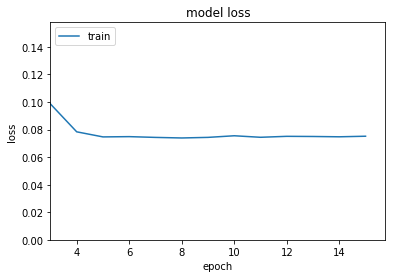

<Figure size 432x288 with 0 Axes>

In [8]:
# summarize history for loss
plt.plot(history.history['loss'])
###plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xlim(3, None)
plt.ylim(ymax = 1.2*history.history['loss'][min(len(history.history['loss']),3)-1], ymin = 0)
print("history",history.history['loss'])

auxName = 'pretraining_'+str(efficiency)+'_'+str(prob_noise)+'.png'
plt.savefig(auxName)
  
plt.show()
#plt.savefig('training.png')
plt.clf()

In [0]:


def train_model(model, prob_noise=prob_noise):

  print("Training with ADAM optimizer, efficiency, prob_noise = ",efficiency,prob_noise)
  
  #recompile the model with Adam optimizer 
  model.compile(optimizer='Adam', loss='mean_squared_error')

  # patient early stopping
  es_noise = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=12)  # 'val_loss'
  mc_noise = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=1,
                     save_best_only=True)  # 'val_loss'


  #train with fit_generator - generate events on flight
  history=model.fit_generator(data_generator(prob_noise=prob_noise, n_tracks=mean_tracks),
                            steps_per_epoch=steps_per_epoch,
                            #validation_data=data_generator(), 
                            #validation_steps=steps_per_epoch,
                            epochs = epochs, callbacks=[es_noise, mc_noise])


  # load the saved model
  model = load_model('best_model.h5')

  # summarize history for loss
  plt.plot(history.history['loss'])
  ###plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.xlim(3, None)
  plt.ylim(ymax = 1.2*history.history['loss'][min(len(history.history['loss']),3)-1], ymin = 0)
  print("history",history.history['loss'])

  auxName = 'training_'+str(efficiency)+'_'+str(prob_noise)+'.png'
  plt.savefig(auxName)
  
  plt.show()
  plt.clf()
  
  
    #recompile the model with SGD optimizer 
  model.compile(optimizer='SGD', loss='mean_squared_error')

  

  #train with fit_generator - generate events on flight
  history=model.fit_generator(data_generator(prob_noise=prob_noise, n_tracks=mean_tracks),
                            steps_per_epoch=steps_per_epoch,
                            #validation_data=data_generator(), 
                            #validation_steps=steps_per_epoch,
                            epochs = post_epochs, callbacks=[es_noise, mc_noise])



  # load the saved model
  model = load_model('best_model.h5')
  
  # summarize history for loss
  plt.plot(history.history['loss'])
  ###plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.xlim(3, None)
  plt.ylim(ymax = 1.2*history.history['loss'][min(len(history.history['loss']),3)-1], ymin = 0)
  print("history",history.history['loss'])

  auxName = 'trainingSGD_'+str(efficiency)+'_'+str(prob_noise)+'.png'
  plt.savefig(auxName)
  
  plt.show()
  plt.clf()

In [0]:
def generate_testdata(prob_noise = prob_noise):

  print("Generate test data, efficiency, prob_noise = ",efficiency,prob_noise)

  ###x_train, y_train = gen_n_tracks(batch_size=batch_size).next()
  x_test, y_test = gen_n_tracks(batch_size=batch_size, n_tracks=mean_tracks).next()

  # add noise
  noise_test = gen_noise(batch_size=batch_size, prob_noise=prob_noise).next()
  x_test  = x_test+noise_test
 

  x_test = x_test.astype('int')
  #clip to 1
  x_test = np.clip(x_test, 0, 1)

  return x_test, y_test

In [0]:

def plot_sample():

  #plot sample events
  print("plotting sample events, efficiency, prob_noise = ",efficiency,prob_noise)

  for n in range(1):
    for k in range(int(100*(prob_noise+0.10))):
      rnumber = np.random.randint(0,len(x_test))
      x,y,z = x_test[rnumber,0].nonzero()
      from mpl_toolkits.mplot3d import Axes3D
      fig = plt.figure()
      ax = fig.add_subplot(111, projection='3d')
      ax.scatter(x, y, z, zdir='z', c= 'red', s=5, alpha=0.9)
    
    
      ax.set_xlabel('X')
      ax.set_ylabel('Y')
      ax.set_zlabel('Z (depth)')
  
    
      for j in range(len(y_test[rnumber])):
      # Data for a three-dimensional line
         #print("index ",k)
         #print("ytrain ", y_train[rnumber])
         zline = np.linspace(0, 28, 100)
         xline = y_test[rnumber,j,0]*det_width+y_test[rnumber,j,1]*slope_mult*zline 
         yline = y_test[rnumber,j,2]*det_width+y_test[rnumber,j,3]*slope_mult*zline 
###       xline = 100*y_test[rnumber,k,0]+100/slope_scale*y_test[rnumber,k,1]*zline
###       yline = 100*y_test[rnumber,k,2]+100/slope_scale*y_test[rnumber,k,3]*zline
         ax.plot3D(xline, yline, zline,  'green', alpha=0.5)
    
      ax.view_init(elev=35., azim=45)
      ax.scatter([0,det_width],[0,det_width],[0,det_depth], c= 'blue', s=0)

      # set axes range
      ax.set_xlim3d(0,det_width)
      ax.set_xlim3d(0,det_width)
      ax.set_xlim3d(0,det_depth)
      #ax.axis('equal')

      print('event_'+str(efficiency)+"_"+str(prob_noise)+"_"+str(k)+'.png')
      plt.savefig('event_'+str(efficiency)+"_"+str(prob_noise)+"_"+str(k)+'.png')
      plt.show()
  
#  plt.imshow(x_train[np.random.randint(0,len(x_train)),0])
#  plt.show()
#plt.savefig('event.png')
#plt.clf()






#sys.exit("Stopping here")



In [0]:
def predict(model):

  print("Predict with trained NN, efficiency, prob_noise = ",efficiency,prob_noise)

  start_pattern_time = time.time()

  if 'COLAB_TPU_ADDR'  in os.environ:
  # converting tpu_model to the cpu_model
   model = model.sync_to_cpu()


# make a prediction
#batch_size=2
  print("x_test.shape", x_test.shape)

  y_new = model.predict(x_test)

  print (model.summary())
  print("y_new.shape", y_new.shape)

  end_pattern_time = time.time()

  return y_new

In [0]:
def plot_predict(y_new = y_new):

  print("Plot fitted parameters, efficiency, prob_noise = ",efficiency,prob_noise)

  print("y_new shape :: ",y_new.shape)
  
  # plot fitted parameters
  y0_true = []
  y0_pred = []
  for i in range(len(x_test)):
    y0_true.append((y_test[i])[0])
    y0_pred.append((y_new[i])[0])
    if i<6:
        print ("true ",y_test[i])
        print ("pred ",y_new[i])
        #print (y0_true[i], y0_pred[i])
  plt.plot(y0_true, y0_pred, ".")
  plt.ylabel('predicted')
  plt.xlabel('true')
  print('params_scatter_'+str(efficiency)+'_'+str(prob_noise)+'.png')
  plt.savefig('params_scatter_'+str(efficiency)+'_'+str(prob_noise)+'.png')
 
  plt.show()
  plt.clf()


  # the histogram of the data
  columns_true = zip(*y0_true) #transpose rows to columns
  columns_pred = zip(*y0_pred) #transpose rows to columns
  #diff = columns_pred-columns_true
  diff = tuple(np.subtract(columns_pred,columns_true))

  plt.subplot(1, 2, 1)
  n, bins, patches = plt.hist(diff[0], 50, normed=1, facecolor='green', alpha=0.30)
  # Fit a normal distribution to the data:
  mu, std = norm.fit(diff[0])
  # Plot the PDF.
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)
  plt.title("slope X: mu = %.2f,  std = %.2f" % (mu, std))
  plt.plot(x, p, 'k', linewidth=2)

  plt.subplot(1, 2, 2)
  n, bins, patches = plt.hist(diff[1], 50, normed=1, facecolor='green', alpha=0.30)
  # Fit a normal distribution to the data:
  mu, std = norm.fit(diff[1])
  # Plot the PDF.
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)
  plt.title("offset X: mu = %.2f,  std = %.2f" % (mu, std))
  plt.plot(x, p, 'k', linewidth=2)

  print('params_1_'+str(efficiency)+'_'+str(prob_noise)+'.png')
  plt.savefig('params_1_'+str(efficiency)+'_'+str(prob_noise)+'.png')

  plt.show()
  plt.clf()

  plt.subplot(1, 2, 1)
  n, bins, patches = plt.hist(diff[2], 50, normed=1, facecolor='green', alpha=0.30)
  # Fit a normal distribution to the data:
  mu, std = norm.fit(diff[2])
  # Plot the PDF.
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)
  plt.title("slope Y: mu = %.2f,  std = %.2f" % (mu, std))
  plt.plot(x, p, 'k', linewidth=2)

  plt.subplot(1, 2, 2)
  n, bins, patches = plt.hist(diff[3], 50, normed=1, facecolor='green', alpha=0.30)
  # Fit a normal distribution to the data:
  mu, std = norm.fit(diff[3])
  # Plot the PDF.
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)
  plt.title("offset Y: mu = %.2f,  std = %.2f" % (mu, std))
  plt.plot(x, p, 'k', linewidth=2)


  print('params_2_'+str(efficiency)+'_'+str(prob_noise)+'.png')
  plt.savefig('params_2_'+str(efficiency)+'_'+str(prob_noise)+'.png')


  plt.show()
  plt.clf()

  



In [0]:

def plot_predict_event(y_new = y_new):

  #plot sample events with true and reconstructed tracks
  print("Plot events with predicted tracks, efficiency, prob_noise = ",efficiency,prob_noise)
  
  print("y_new shape :: ",y_new.shape)
  

  for n in range(8):
    for k in range(int(100*(prob_noise+0.10))):
      rnumber = np.random.randint(0,len(x_test))
      x,y,z = x_test[rnumber,0].nonzero()
      from mpl_toolkits.mplot3d import Axes3D
      fig = plt.figure()
      ax = fig.add_subplot(111, projection='3d')
      ax.scatter(x, y, z, zdir='z', c= 'red', s=5, alpha=0.9)
    
      ax.set_xlabel('X')
      ax.set_ylabel('Y')
      ax.set_zlabel('Z (depth)')
  
  
   
    
      for j in range(len(y_test[rnumber])):
      # Data for a three-dimensional line
         #print("index ",k)
         #print("ytest ", y_test[rnumber])
         zline = np.linspace(0, 28, 100)
         xline = y_test[rnumber,j,0]*det_width+y_test[rnumber,j,1]*slope_mult*zline 
         yline = y_test[rnumber,j,2]*det_width+y_test[rnumber,j,3]*slope_mult*zline 
###       xline = 100*y_test[rnumber,k,0]+100/slope_scale*y_test[rnumber,k,1]*zline
###       yline = 100*y_test[rnumber,k,2]+100/slope_scale*y_test[rnumber,k,3]*zline
         ax.plot3D(xline, yline, zline,  'green', alpha=0.5)
         xline = y_new[rnumber,j,0]*det_width+y_new[rnumber,j,1]*slope_mult*zline 
         yline = y_new[rnumber,j,2]*det_width+y_new[rnumber,j,3]*slope_mult*zline  
###       xline = 100*y_new[rnumber,k,0]+100/slope_scale*y_new[rnumber,k,1]*zline
###       yline = 100*y_new[rnumber,k,2]+100/slope_scale*y_new[rnumber,k,3]*zline
         ax.plot3D(xline, yline, zline,  'blue', alpha=0.5)
    
      #ax.view_init(elev=10., azim=0)
      ax.scatter([0,det_width],[0,det_width],[0,det_depth], c= 'blue', s=0)

      # set axes range
      ax.set_xlim3d(0,det_width)
      ax.set_xlim3d(0,det_width)
      ax.set_xlim3d(0,det_depth)
      #ax.axis('equal')

      print('event_res_'+str(efficiency)+"_"+str(prob_noise)+"_"+str(k)+'.png')
      plt.savefig('event_res_'+str(efficiency)+"_"+str(prob_noise)+"_"+str(k)+'.png')


      
      plt.show()
  


In [0]:
def write_predict(y_new = y_new):

  print("Write output data, efficiency, prob_noise = ",efficiency,prob_noise)

  print("y_new shape :: ",y_new.shape)
  

  # write the output - true and reconstructed tracks	
  print("Writing dnn_output.txt by printing y_new and y_test: ",y_new.shape)  
  f= open("dnn_output"+str(efficiency)+"_"+str(prob_noise)+".txt","w+")
  for i in range(len(y_test)):
    k = len(y_test[i])
    f.write("%s \n" % k)
    for j in range(len(y_test[i])):
      for l in range(len(y_test[i][j])):
        f.write("%s " % y_test[i][j][l])
      f.write("\n")
    for j in range(len(y_new[i])):
      for l in range(len(y_new[i][j])):
        f.write("%s " % y_new[i][j][l])      
      f.write("\n")
    
  f.close()





number of tracks  2
Training with ADAM optimizer, efficiency, prob_noise =  0.9 0
Epoch 1/512
15/16 [===========================>..] - ETA: 4s - loss: 0.5053
Epoch 00001: loss improved from inf to 0.47853, saving model to best_model.h5
16/16 [==============================] - 73s 5s/step - loss: 0.4785
Epoch 2/512
15/16 [===========================>..] - ETA: 2s - loss: 0.0652
Epoch 00002: loss improved from 0.47853 to 0.06458, saving model to best_model.h5
16/16 [==============================] - 41s 3s/step - loss: 0.0646
Epoch 3/512
15/16 [===========================>..] - ETA: 2s - loss: 0.0537
Epoch 00003: loss improved from 0.06458 to 0.05353, saving model to best_model.h5
16/16 [==============================] - 42s 3s/step - loss: 0.0535
Epoch 4/512
15/16 [===========================>..] - ETA: 2s - loss: 0.0496
Epoch 00004: loss improved from 0.05353 to 0.04925, saving model to best_model.h5
16/16 [==============================] - 42s 3s/step - loss: 0.0493
Epoch 5/512
15/16 

W1119 17:56:24.048506 139936381134720 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/init_ops.py:97: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1119 17:56:24.053236 139936381134720 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/init_ops.py:97: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 00090: early stopping


W1119 17:56:24.319144 139936381134720 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/init_ops.py:97: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


history [0.4785307552665472, 0.06457707937806845, 0.05353244044817984, 0.04925419087521732, 0.043687583645805717, 0.03857281897217035, 0.03409821470268071, 0.02891895466018468, 0.02604085602797568, 0.02316850412171334, 0.020508513785898685, 0.01793580991216004, 0.01657155528664589, 0.015288649825379252, 0.013696136476937681, 0.01256406307220459, 0.01171196048380807, 0.010686063440516591, 0.010359079285990447, 0.009921234333887696, 0.009910546476021409, 0.008984056417830288, 0.00815398950362578, 0.008202904631616548, 0.008278186462121084, 0.008031651086639613, 0.007491429307265207, 0.007350410858634859, 0.007232738076709211, 0.006994666764512658, 0.007136307132896036, 0.007243342988658696, 0.0066582550934981555, 0.006816318636992946, 0.006410877860616893, 0.006075573473935947, 0.006383259256836027, 0.006548648903844878, 0.00635801674798131, 0.00588165846420452, 0.00628166162641719, 0.006206952617503703, 0.00543534749886021, 0.005775252415332943, 0.005924930825131014, 0.00594798245583660

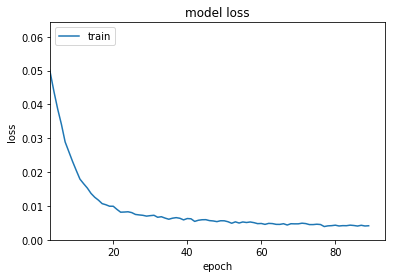

Epoch 1/16
15/16 [===========================>..] - ETA: 2s - loss: 0.0038
Epoch 00001: loss improved from 0.00391 to 0.00386, saving model to best_model.h5
16/16 [==============================] - 47s 3s/step - loss: 0.0039
Epoch 2/16
15/16 [===========================>..] - ETA: 2s - loss: 0.0041
Epoch 00002: loss did not improve from 0.00386
16/16 [==============================] - 41s 3s/step - loss: 0.0041
Epoch 3/16
15/16 [===========================>..] - ETA: 2s - loss: 0.0043
Epoch 00003: loss did not improve from 0.00386
16/16 [==============================] - 41s 3s/step - loss: 0.0043
Epoch 4/16
15/16 [===========================>..] - ETA: 2s - loss: 0.0038
Epoch 00004: loss improved from 0.00386 to 0.00382, saving model to best_model.h5
16/16 [==============================] - 41s 3s/step - loss: 0.0038
Epoch 5/16
15/16 [===========================>..] - ETA: 2s - loss: 0.0041
Epoch 00005: loss did not improve from 0.00382
16/16 [==============================] - 41s 3s/

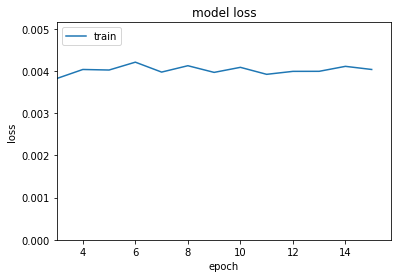

Generate test data, efficiency, prob_noise =  0.9 0
plotting sample events, efficiency, prob_noise =  0.9 0
event_0.9_0_0.png


<Figure size 432x288 with 0 Axes>

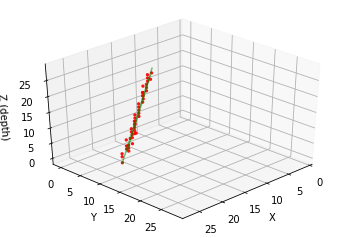

event_0.9_0_1.png


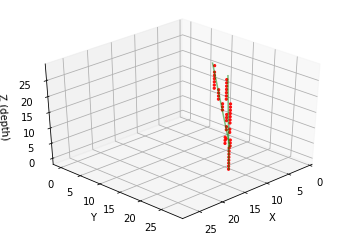

event_0.9_0_2.png


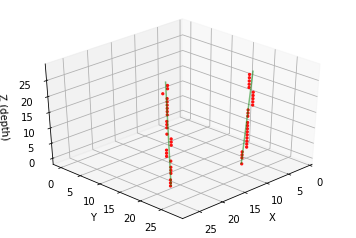

event_0.9_0_3.png


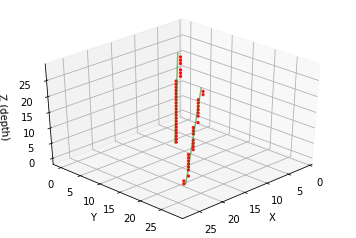

event_0.9_0_4.png


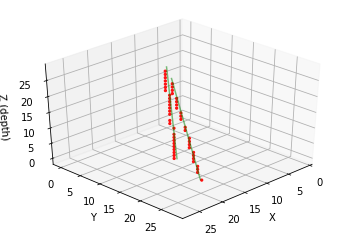

event_0.9_0_5.png


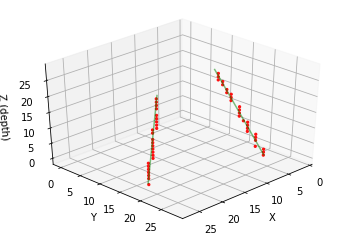

event_0.9_0_6.png


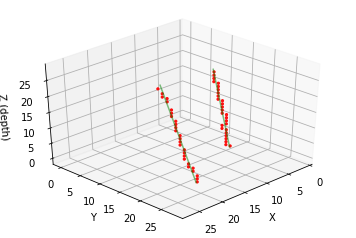

event_0.9_0_7.png


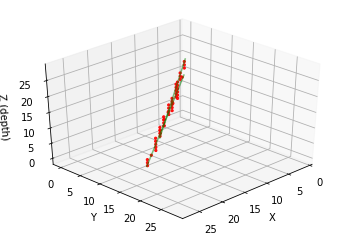

event_0.9_0_8.png


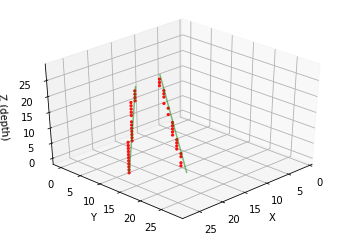

event_0.9_0_9.png


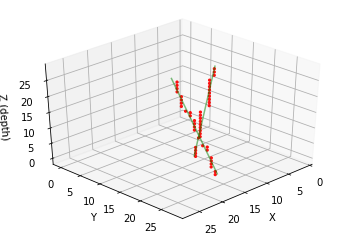

Predict with trained NN, efficiency, prob_noise =  0.9 0
x_test.shape (5000, 1, 28, 28, 28)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 28, 1)     0         
_________________________________________________________________
conv3d (Conv3D)              (None, 26, 26, 26, 32)    896       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 24, 24, 24, 32)    27680     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 12, 12, 12, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 10, 10, 128)   110720    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 8, 8, 128)      442496    
______________________________

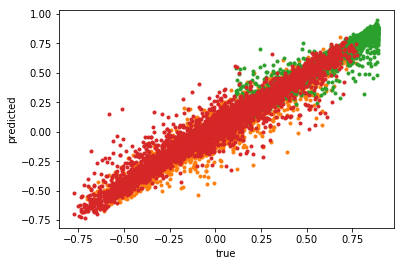

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


params_1_0.9_0.png


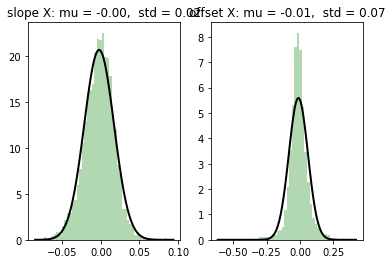

params_2_0.9_0.png


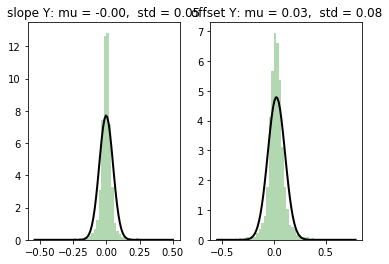

Plot events with predicted tracks, efficiency, prob_noise =  0.9 0
y_new shape ::  (5000, 2, 4)
event_res_0.9_0_0.png


<Figure size 432x288 with 0 Axes>

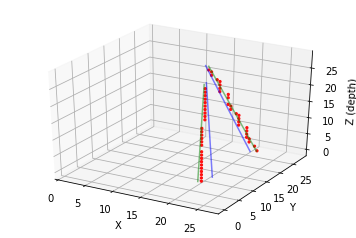

event_res_0.9_0_1.png


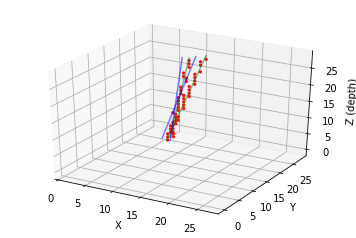

event_res_0.9_0_2.png


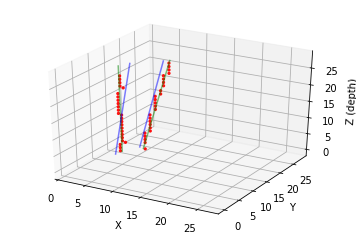

event_res_0.9_0_3.png


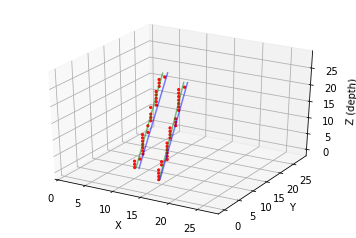

event_res_0.9_0_4.png


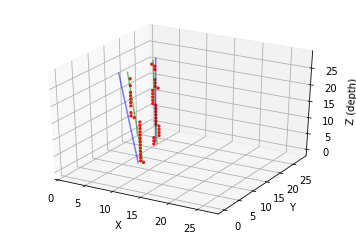

event_res_0.9_0_5.png


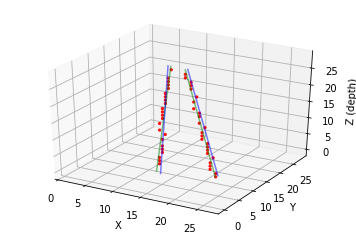

event_res_0.9_0_6.png


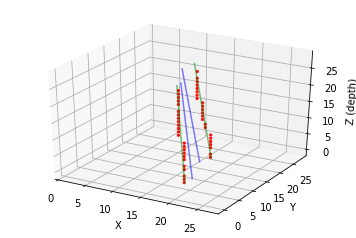

event_res_0.9_0_7.png


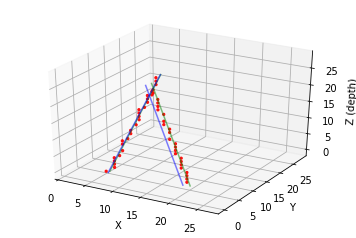

event_res_0.9_0_8.png


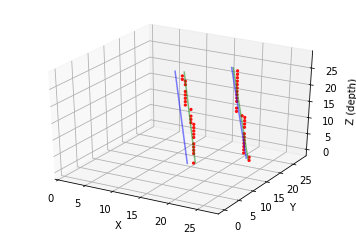

event_res_0.9_0_9.png


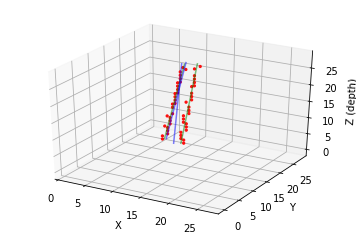

event_res_0.9_0_0.png


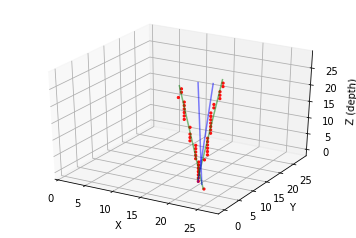

event_res_0.9_0_1.png


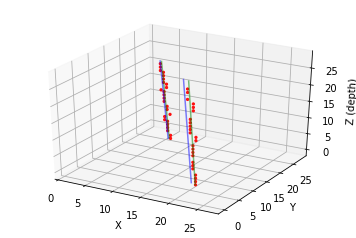

event_res_0.9_0_2.png


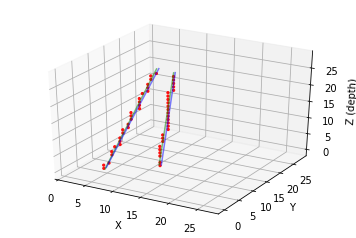

event_res_0.9_0_3.png


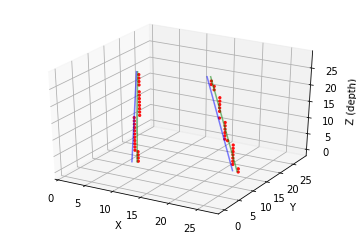

event_res_0.9_0_4.png


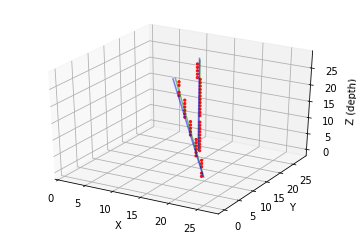

event_res_0.9_0_5.png


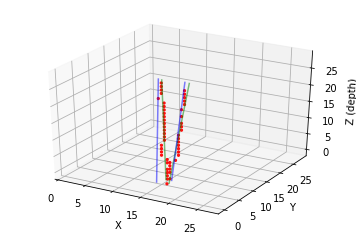

event_res_0.9_0_6.png


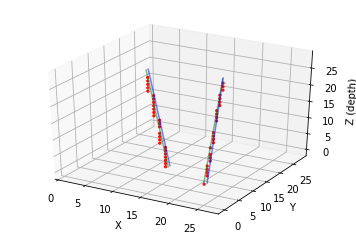

event_res_0.9_0_7.png


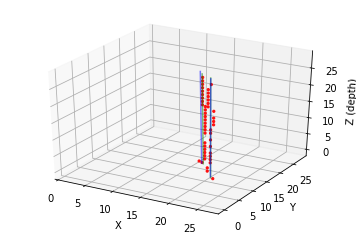

event_res_0.9_0_8.png


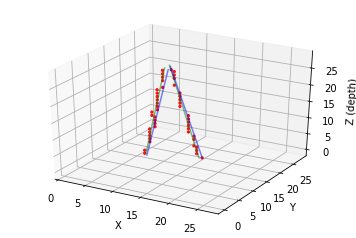

event_res_0.9_0_9.png


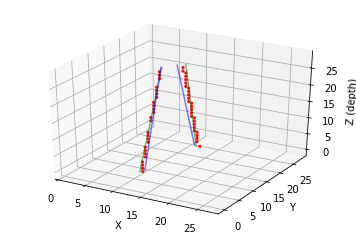

event_res_0.9_0_0.png


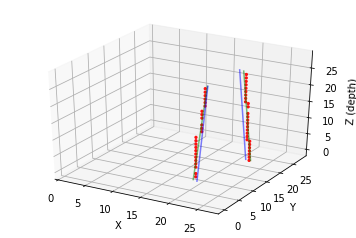

event_res_0.9_0_1.png


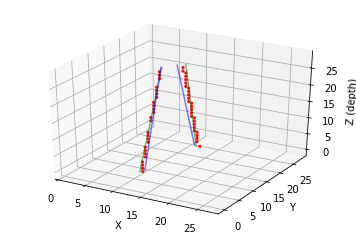

event_res_0.9_0_2.png


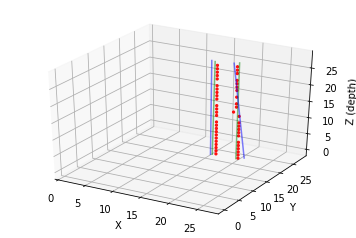

event_res_0.9_0_3.png


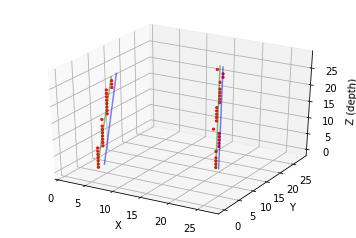

event_res_0.9_0_4.png


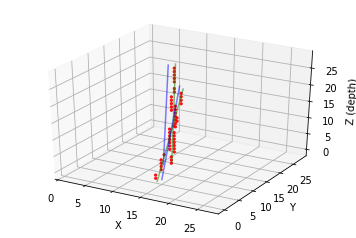

event_res_0.9_0_5.png


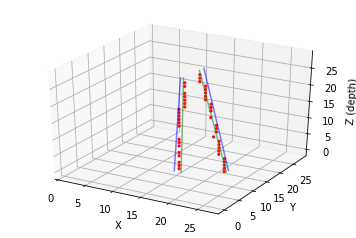

event_res_0.9_0_6.png


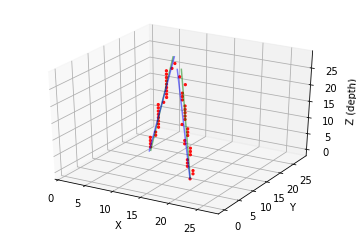

event_res_0.9_0_7.png


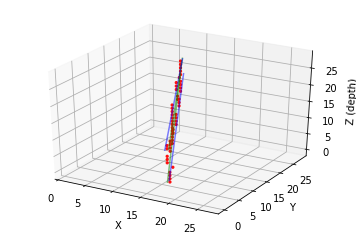

event_res_0.9_0_8.png


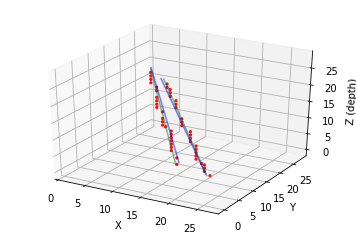

event_res_0.9_0_9.png


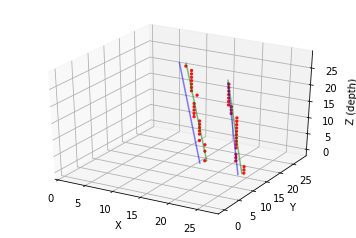

event_res_0.9_0_0.png


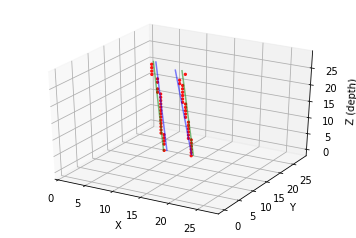

event_res_0.9_0_1.png


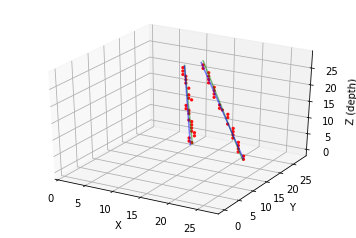

event_res_0.9_0_2.png


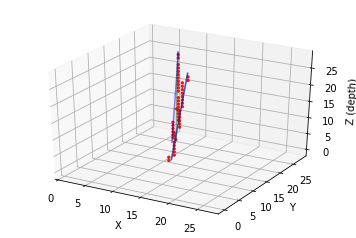

event_res_0.9_0_3.png


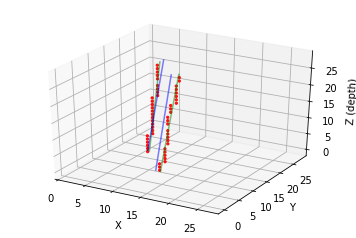

event_res_0.9_0_4.png


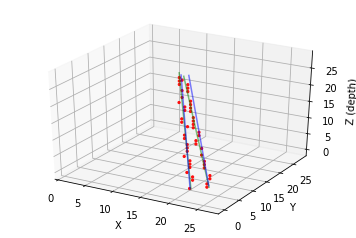

event_res_0.9_0_5.png


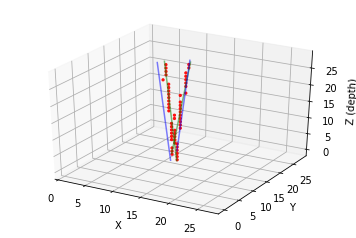

event_res_0.9_0_6.png


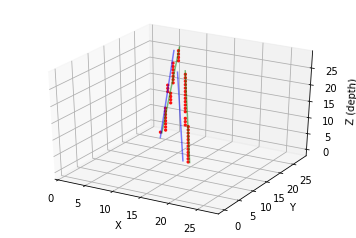

event_res_0.9_0_7.png


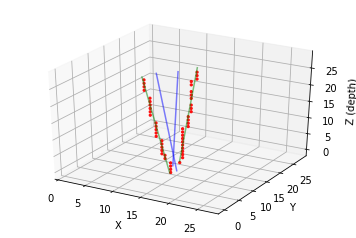

event_res_0.9_0_8.png


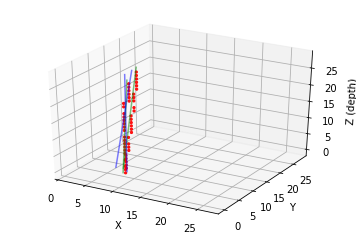

event_res_0.9_0_9.png


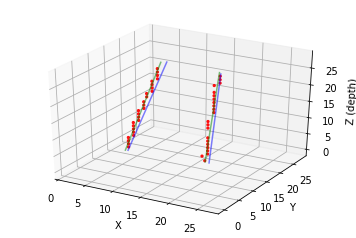

event_res_0.9_0_0.png


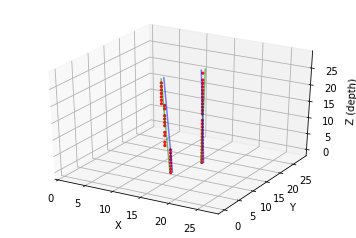

event_res_0.9_0_1.png


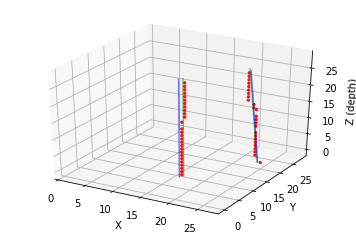

event_res_0.9_0_2.png


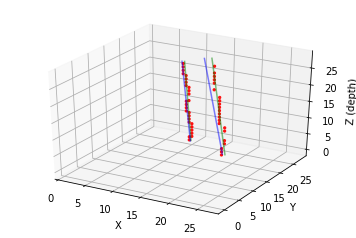

event_res_0.9_0_3.png


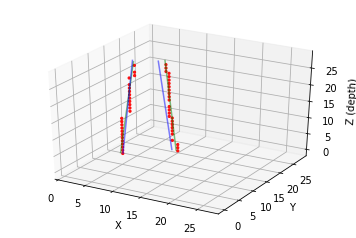

event_res_0.9_0_4.png


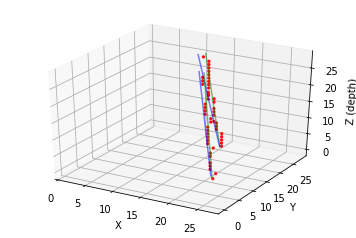

event_res_0.9_0_5.png


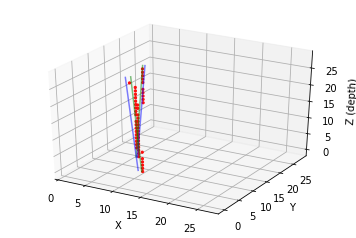

event_res_0.9_0_6.png


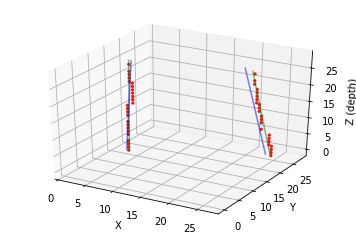

event_res_0.9_0_7.png


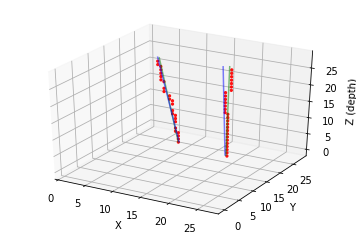

event_res_0.9_0_8.png


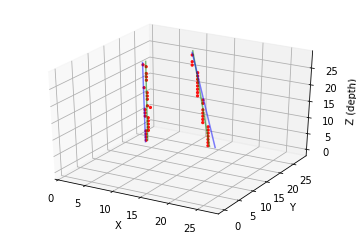

event_res_0.9_0_9.png


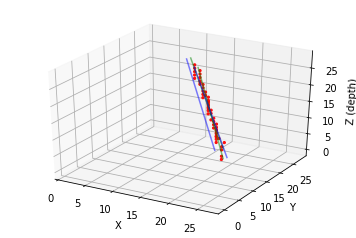

event_res_0.9_0_0.png


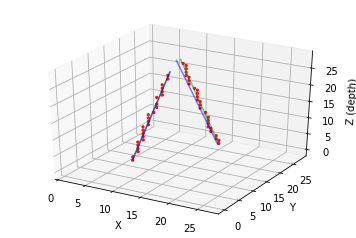

event_res_0.9_0_1.png


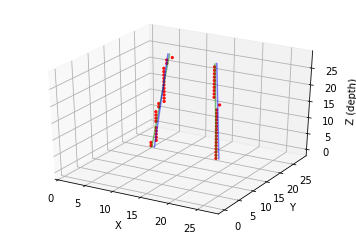

event_res_0.9_0_2.png


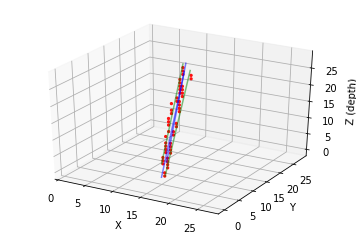

event_res_0.9_0_3.png


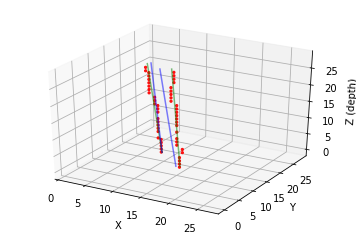

event_res_0.9_0_4.png


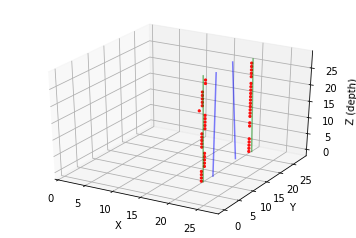

event_res_0.9_0_5.png


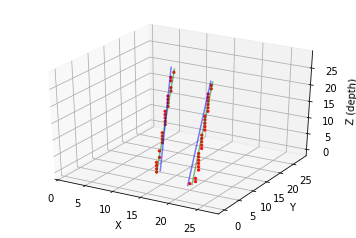

event_res_0.9_0_6.png


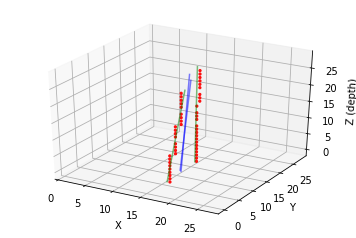

event_res_0.9_0_7.png


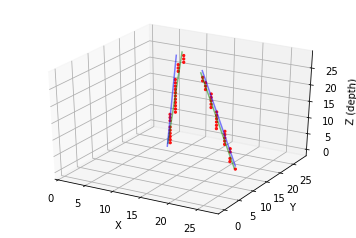

event_res_0.9_0_8.png


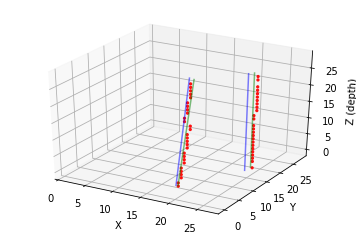

event_res_0.9_0_9.png


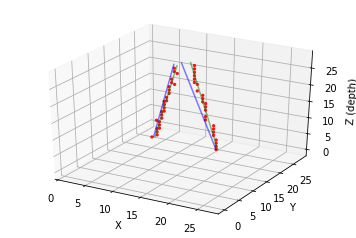

event_res_0.9_0_0.png


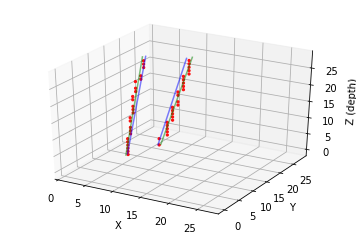

event_res_0.9_0_1.png


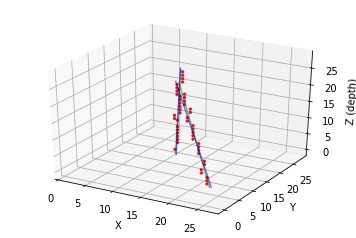

event_res_0.9_0_2.png


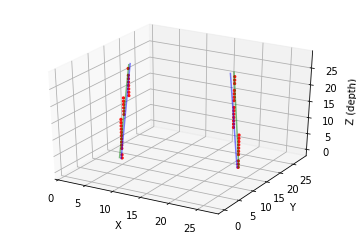

event_res_0.9_0_3.png


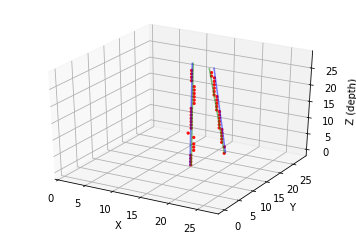

event_res_0.9_0_4.png


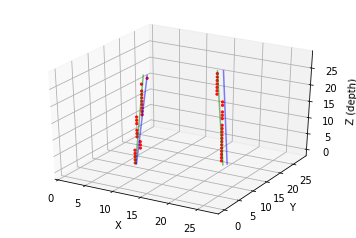

event_res_0.9_0_5.png


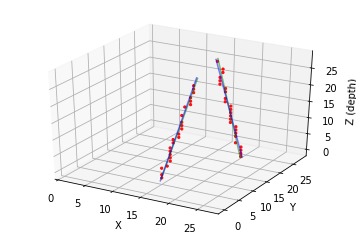

event_res_0.9_0_6.png


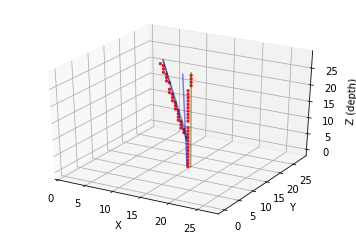

event_res_0.9_0_7.png


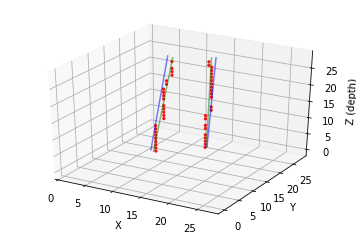

event_res_0.9_0_8.png


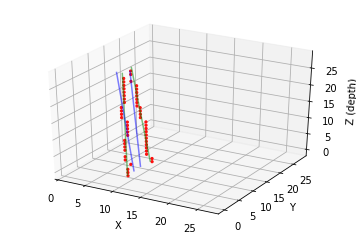

event_res_0.9_0_9.png


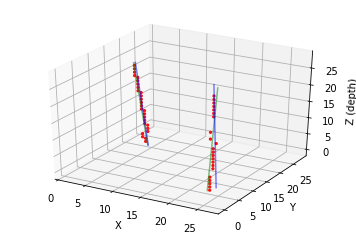

event_res_0.9_0_0.png


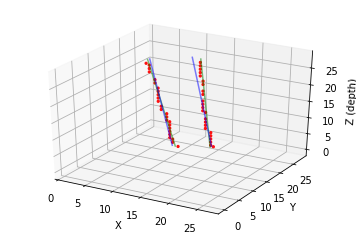

event_res_0.9_0_1.png


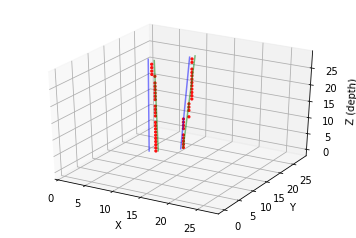

event_res_0.9_0_2.png


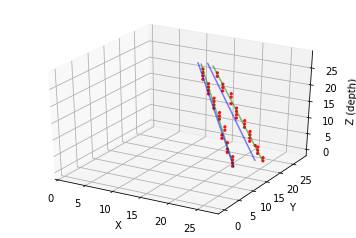

event_res_0.9_0_3.png


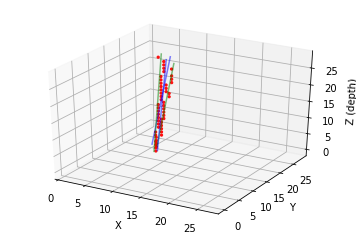

event_res_0.9_0_4.png


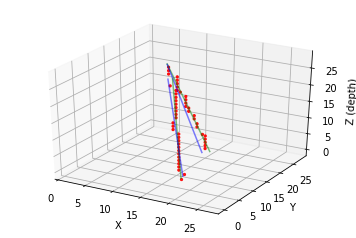

event_res_0.9_0_5.png


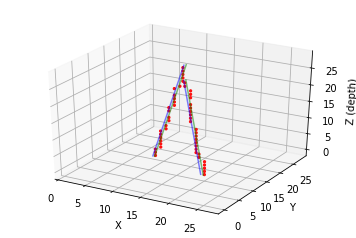

event_res_0.9_0_6.png


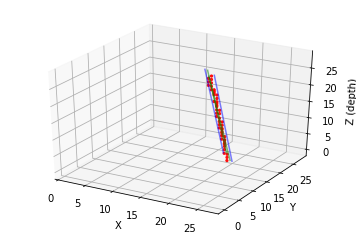

event_res_0.9_0_7.png


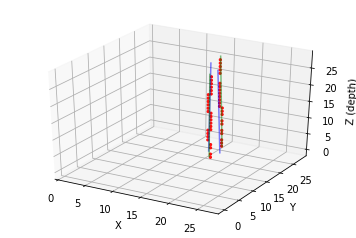

event_res_0.9_0_8.png


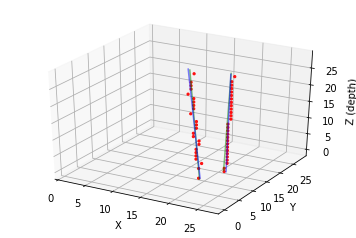

event_res_0.9_0_9.png


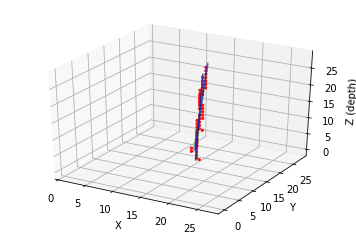

Write output data, efficiency, prob_noise =  0.9 0
y_new shape ::  (5000, 2, 4)
Writing dnn_output.txt by printing y_new and y_test:  (5000, 2, 4)
  adding: content/event_0.9_0.03_0.png (deflated 2%)
  adding: content/event_0.9_0.03_10.png (deflated 2%)
  adding: content/event_0.9_0.03_11.png (deflated 2%)
  adding: content/event_0.9_0.03_12.png (deflated 2%)
  adding: content/event_0.9_0.03_1.png (deflated 2%)
  adding: content/event_0.9_0.03_2.png (deflated 2%)
  adding: content/event_0.9_0.03_3.png (deflated 2%)
  adding: content/event_0.9_0.03_4.png (deflated 2%)
  adding: content/event_0.9_0.03_5.png (deflated 2%)
  adding: content/event_0.9_0.03_6.png (deflated 2%)
  adding: content/event_0.9_0.03_7.png (deflated 2%)
  adding: content/event_0.9_0.03_8.png (deflated 2%)
  adding: content/event_0.9_0.03_9.png (deflated 2%)
  adding: content/event_0.9_0_0.png (deflated 5%)
  adding: content/event_0.9_0_1.png (deflated 5%)
  adding: content/event_0.9_0_2.png (deflated 5%)
  adding: c

In [0]:

print("number of tracks ",mean_tracks)



for prob_noise in [0.000, 0.050]:
#for prob_noise in [0, 0.050, 0.100, 0.150, 0.200]:
#for prob_noise in [0.001, 0.004]:
  
  train_model(model, prob_noise)
  

  x_test, y_test = generate_testdata(prob_noise)
  plot_sample()
  
  y_new = predict(model)
  print("y_new shape: ",y_new.shape)
  plot_predict(y_new)
  plot_predict_event(y_new)
  
  write_predict(y_new)
  
  !zip  /content/dnn_output_0.zip /content/*.png /content/*.txt

In [0]:


end_training_time = time.time()



!zip  /content/dnn_output_final.zip /content/*.png /content/*.txt



print ("    ")
print ("###########################################################")
print ("    ")
print ("CPU usage: ")
print ("Deep NN training:      ", end_training_time-start_training_time)
#print ("Pattern recognition:   ", end_pattern_time-start_pattern_time)
#print ("Track fitting:         ", end_fit_time-start_fit_time)
print ("    ")
print ("###########################################################")
print ("    ")

